### Loading the dataset from the csv file

In [1]:
import pandas as pd

df = pd.read_csv("cleaned_lower_politifact.csv", ',')
X = df['text'].values
labels = df['label'].values

### Data Processing — convert to lower case and remove punctuation

In [2]:
# import re, string

# for i in range(X.size):
    
#     words = X[i].split()
#     filtered_list = []
#     for word in words:
#         pattern = re.compile('[^\u0000-\u007F]+', re.UNICODE)  #Remove all non-alphanumeric characters
        
#         word = pattern.sub('', word)
#         word = word.translate(str.maketrans('', '', string.punctuation))
#         word = word.lower()

#         filtered_list.append(word)
#         result = ' '.join(filtered_list)
        
#     X[i] = result      

# list1 = [['id', 'text', 'label']]
# for i in range(0, len(X)):
#       list1.append([df['id'][i], X[i], df['label'][i]])
# df1 = pd.DataFrame(list1)
# df1.to_csv('cleaned_lower_politifact.csv',sep=',',index = False ,header = False)

### Tokenize — Create Vocab to Int mapping dictionary

Ιn most of the NLP tasks, you will create an index mapping dictionary in such a way that your frequently occurring words are assigned lower indexes. One of the most common way of doing this is to use ```Counter``` method from ```Collections``` library.

In [3]:
from collections import Counter

words_list = []
articles_list = []
for i in range(X.size):
    
    articles_list.append(X[i])
    words = X[i].split()
    words_list.append(words)

flat_words_list = [item for sublist in words_list for item in sublist]
count_words = Counter(flat_words_list)

total_words = len(flat_words_list)
sorted_words = count_words.most_common(total_words)
#print(count_words)
#print(total_words)
#print(sorted_words)

In order to create a vocab to int mapping dictionary, you would simply do this

In [4]:
vocab_to_int = {w:i for i, (w,c) in enumerate(sorted_words)}

There is a small trick here, in this mapping index will start from 0 i.e. mapping of ‘the’ will be 0. But later on we are going to do padding for shorter articles and conventional choice for padding is 0. So we need to start this indexing from 1

In [5]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

### Tokenize — Encode the words

So far we have created a) list of articles and b) index mapping dictionary using vocab from all our articles. All this was to create an encoding of articles (replace words in our articles by integers)

In [6]:
articles_int = []
for aricle in articles_list:
    a = [vocab_to_int[w] for w in aricle.split()]
    articles_int.append(a)
print (articles_int[:2])

[[673, 13, 18, 10064, 759, 2, 36, 5, 335, 16, 26, 272, 8207, 1593, 1117, 127, 11, 129, 912, 63, 144, 138, 9000, 49, 496, 2429, 209, 120, 3, 1967, 419, 44, 2555, 2517, 11510, 72, 32, 364, 2, 2133, 3502, 513, 13815, 78, 8, 3144, 171, 4808, 61, 24, 154, 1, 92, 8, 6983, 331, 737, 3, 5, 5819, 726, 4, 441, 78, 13816, 2133, 4097, 2381, 10065, 2, 11511, 1, 172, 6156, 3, 1, 1854, 1930, 1477, 331, 737, 17, 5, 187, 4, 46, 7537, 166, 37, 5820, 1995, 4, 1665, 11512, 4, 1, 1246, 491, 13815, 11513, 18208, 18209, 48, 64, 44, 180, 60, 2517, 6, 1045, 5, 181, 43, 130, 28, 1665, 11512, 13, 51, 18, 2049, 27, 1259, 6, 15, 1478, 9001, 8, 1067, 2, 46, 6157, 1359, 4, 5, 147, 610, 619, 62, 7538, 1338, 4, 3812, 1125, 10066, 472, 1, 135, 18210, 35, 53, 3614, 1322, 37, 1593, 7, 1, 639, 4, 2049, 1, 6157, 1359, 2134, 42, 248, 344, 5821, 62, 993, 3, 43, 5526, 13817, 210, 1576, 6158, 117, 5, 13818, 1360, 394, 13, 8, 20, 5, 13819, 2024, 6, 86, 2518, 6158, 36, 32, 20, 46, 2024, 6, 24, 30, 7539, 2, 1, 1385, 3, 43, 659, 4

Note: what we have created now is a list of lists. Each individual article is a list of integer values and all of them are stored in one huge list

### Analyze Article Length

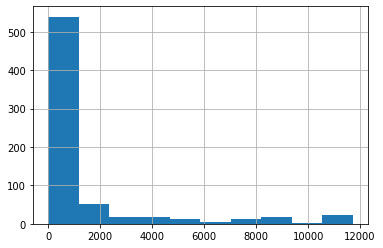

count      699.000000
mean      1537.991416
std       2677.192407
min         10.000000
25%        250.000000
50%        477.000000
75%       1059.000000
max      11714.000000
dtype: float64

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

articles_len = [len(x) for x in articles_int]
pd.Series(articles_len).hist()
plt.show()
pd.Series(articles_len).describe()

__Observations__ :

1. Mean article length = __1538__
2. Most of the articles are around 1000 words or more
3. There are quite a few articles that are extremely long, we can manually investigate them to check whether we need to include or exclude them from our analysis

### Removing Outliers — Getting rid of extremely long or short articles

In [8]:
articles_int = [ articles_int[i] for i, l in enumerate(articles_len) if l<1100 ]
print(len(labels))

labels = [ labels[i] for i, l in enumerate(articles_len) if l<1100 ]
print(len(labels))

699
528


### Analyze Article Length (after removing outliers)

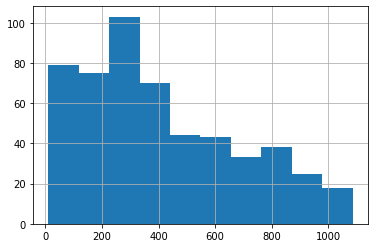

count     528.000000
mean      410.003788
std       276.342183
min        10.000000
25%       205.500000
50%       341.000000
75%       605.000000
max      1087.000000
dtype: float64

In [9]:

articles_len = [len(x) for x in articles_int]
pd.Series(articles_len).hist()
plt.show()
pd.Series(articles_len).describe()

### Padding / Truncating the remaining data

To deal with both short and long articles, we will pad or truncate all our articles to a specific length. We define this length by __Sequence Length__. This sequence length is same as number of time steps for LSTM layer.

For articles shorter than __seq_length__, we will pad with 0s. For articles longer than __seq_length__ we will truncate them to the first seq_length words.

In [10]:
import numpy as np

def pad_features(articles_int, seq_length):

    ''' Return features of articles_int, where each article is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(articles_int), seq_length), dtype = int)
    
    for i, article in enumerate(articles_int):
        article_len = len(article)
        
        if article_len <= seq_length:
            zeroes = list(np.zeros(seq_length-article_len))
            new = zeroes + article
        elif article_len > seq_length:
            new = article[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

Note: We are creating/maintaining a 2D array structure as we created for articles_int. Output will look like this

In [11]:
features = pad_features(articles_int, 200)
print(features)

[[  673    13    18 ...     6    24    30]
 [    1   545  1855 ...     2    56  2382]
 [  292    28    95 ... 18216   366    42]
 ...
 [    0     0     0 ...   123  1198   388]
 [   20   149  4454 ...    15    92     3]
 [    0     0     0 ...  1029    85  5705]]


### Training, Validation, Test Dataset Split

Once we have got our data in nice shape, we will split it into training, validation and test sets

train= 80% | valid = 10% | test = 10%

In [12]:
split_frac = 0.8

#train_split
train_x = features[0 : int(split_frac * len(features))]
train_y = labels[0 : int(split_frac * len(features))]       #labels not a numpy array, but list 

remaining_x = features[int(split_frac * len(features)) :]
remaining_y = labels[int(split_frac * len(features)) :]     #list

#validation split
valid_x = remaining_x[0 : int(len(remaining_x) * 0.5)]
valid_y = remaining_y[0 : int(len(remaining_y) * 0.5)]  #list

#test_split
test_x = remaining_x[int(len(remaining_x) * 0.5) :]
test_y = remaining_y[int(len(remaining_y) * 0.5) :]     #list

### Dataloaders and Batching

After creating our training, test and validation data. Next step is to create dataloaders for this data. We can use generator function for batching our data into batches instead we will use a TensorDataset. This is one of a very useful utility in <u>__PyTorch__</u> for using our data with <u>__DataLoaders__</u> with exact same ease as of  <u>__torchvision datasets__</u> 

In [13]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(np.array(train_y)))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(np.array(valid_y)))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(np.array(test_y)))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In order to obtain one batch of training data for visualization purpose we will create a data iterator

In [14]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 200])
Sample input: 
 tensor([[    1,  2537,   258,  ...,    14,  3333,     4],
        [    0,     0,     0,  ...,     1,   104,  3083],
        [ 5261, 15879,   201,  ...,   113,     2,  1853],
        ...,
        [    0,     0,     0,  ...,     1,   110,    84],
        [  211,    56,  2026,  ...,   437,     1,  5122],
        [    1,  3979,  1127,  ...,    76,   832,    45]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
        0, 1])


Here, 50 is the batch size and 500 is the sequence length that we have defined. Now our data prep step is complete and next we will look at the LSTM network architecture for start building our model

### Define the LSTM Network Architecture

![Getting Started](https://miro.medium.com/max/729/1*SICYykT7ybua1gVJDNlajw.png)

The layers are as follows:

0. __Tokenize__ : This is not a layer for LSTM network but a mandatory step of converting our words into tokens (integers)

1. __Embedding Layer__: that converts our word tokens (integers) into embedding of specific size

2. __LSTM Layer__: defined by hidden state dims and number of layers

3. __Fully Connected Layer__: that maps output of LSTM layer to a desired output size

4. __Sigmoid Activation Layer__: that turns all output values in a value between 0 and 1

5. __Output__: Sigmoid output from the last timestep is considered as the final output of this network

###  Define the Model Class

In [15]:
import torch.nn as nn

class ClassificationLSTM(nn.Module):
    """
    The RNN model that will be used to perform classification.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        train_on_gpu =torch.cuda.is_available()

        if (train_on_gpu):
            #print('CUDA is available.  Training on CPU ...')
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            #print('CUDA is not available.  Training on CPU ...')
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

### Training the Network

* __Instantiate the network__

In [16]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int) + 1 # +1 for the 0 padding
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = ClassificationLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)


ClassificationLSTM(
  (embedding): Embedding(30827, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


* __Training Loop__

Most of the code in training loop is pretty standard Deep Learning training code that you might see often in all the implementations that’s using PyTorch framework.

In [28]:
# loss and optimization functions
lr = 0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = lr)


# training params

epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip = 5 # gradient clipping

# check if CUDA is available

train_on_gpu = torch.cuda.is_available() 

# move model to GPU, if available
if(train_on_gpu):
    print( "CUDA is available!  Training on GPU ...")
    net.cuda()

net.train()

# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1
        
        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model

        #inputs = inputs.type(torch.LongTensor) #this line is commented because it throws RunTime error: 
                                                #Expected object of device type cuda but got device type cpu for argument #3
                                                #'index' in call to _th_index_select
        print((h))
        output, h = net(inputs, h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])
                
                
                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                
                inputs = inputs.type(torch.LongTensor)
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

CUDA is available!  Training on GPU ...
(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'), tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 

RuntimeError: Expected hidden[0] size (2, 22, 256), got (2, 50, 256)